# Simulating optical auto correlation of a pulsed laser (with chirp)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack
from scipy import signal
from scipy import interpolate
from scipy import optimize

from IPython.core.debugger import set_trace
from datetime import datetime

Electric field of a laser $E(t)$ with a chirp is relative to the form:

$$E(t) \sim f^{1/2}(t) \cdot \exp\left(-i \omega t - i \phi(t)\right)$$

with the central frequency $w$ and the linear chirp $\phi(t)$:

$$\phi_{gauss}(t) = \frac{a_{gauss} t^2}{2}$$

- for an gaussian pulse $f_{gauss}(t)$ is:
$$f_{gauss}(t) = \left(\frac{A_{gauss}}{\sqrt{2 \cdot \pi \cdot \tau_0 \cdot \tau}} \exp\left(-\frac{t^2}{2 \cdot \tau^2}\right)\right)^2$$

 - with the normalization constant $A_{gauss}$, the pulse duration $\tau_0$, the central frequency $w$ and the chirp coefficient $\alpha$.

 - where $\tau = \sqrt{\alpha^2 / \tau_0^2 + \tau_0^2}$ characterizes the chirped pulse length and $a = \alpha/(\alpha^2+\tau_0^4)$ is the frequency chirp rate.

- for an secant pulse $f_{secant}(t)$ is:
$$f_{secant}(t) = A_{secant} * sech^2\left(\frac{t}{\tau_0}\right) = A_{secant} * \left(\frac{2}{exp(\frac{t}{\tau_0}) + exp(-\frac{t}{\tau_0})}\right)^2$$

 - with the linear chirp:
$$\phi_{secant}(t) = \alpha_{secant}\left(\frac{t}{\tau_0}\right)^2$$


see: 
- Glässl, M., Barth, A. M., Gawarecki, K., MacHnikowski, P., Croitoru, M. D., Lüker, S., … Axt, V. M. (2013). Biexciton state preparation in a quantum dot via adiabatic rapid passage: Comparison between two control protocols and impact of phonon-induced dephasing. Physical Review B - Condensed Matter and Materials Physics, 87(8), 1–8. http://doi.org/10.1103/PhysRevB.87.085303
- Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860).

In [2]:
def gen_tau(alpha, tau_0):
    return np.sqrt(alpha**2 / tau_0**2 + tau_0**2)

def gen_a_gauss(alpha, tau_0):
    return alpha / (alpha**2 + tau_0**4)

def f_gauss(t, A, tau_0, omega, alpha):
    return (A / np.sqrt(2 * np.pi * tau_0 * gen_tau(alpha, tau_0)
                      ) * np.exp(- t**2 / (2 * gen_tau(alpha, tau_0)**2)))**2

def phi_gauss(t, tau_0, alpha):
    return gen_a_gauss(alpha, tau_0) * t**2 / 2

def E_gauss(t, A, tau_0, omega, alpha):
     return f_gauss(t, A, tau_0, omega, alpha
                   )**(1 / 2) * np.exp(-1j * omega * t - 1j * phi_gauss(t, tau_0, alpha))

In [3]:
def delta_phi_gauss(t, tau, tau_0, alpha):
    return phi_gauss(t + tau, tau_0, alpha) - phi_gauss(t, tau_0, alpha)

def delta_phi_secant(t, tau, tau_0, alpha):
    return phi_secant(t + tau, tau_0, alpha) - phi_secant(t, tau_0, alpha)

In [4]:
def f_secant(t, A, tau_0, omega, alpha):
    return A * (2 / (np.exp(t / tau_0) + np.exp(- t / tau_0)))**2

def phi_secant(t, tau_0, alpha):
    return alpha * (t / tau_0)**2

def E_secant(t, A, tau_0, omega, alpha):
     return f_secant(t, A, tau_0, omega, alpha
                   )**(1 / 2) * np.exp(-1j * omega * t - 1j * phi_secant(t, tau_0, alpha))



MaiTai Laser | values
-----------|--------------
repitition rate| 80 MHz
center wavelength (tunable) $\lambda_0$| 700 nm to 1000 nm
power | 3.2 Watt
pulse duration $\tau_0$ | 100 fs - 20 ps

We start with the pulse duration $\tau_0$ in (ps) and choose for the central wavelength $\lambda$ = 785e3 (pm).

In [5]:
tau_0_laser = 0.1
lambda_laser = 785e3

frequency_laser = constants.c / lambda_laser
omega_laser = 2 * np.pi * frequency_laser

We calculate E for different $\alpha$ in (ps)$^2$.

In [6]:
alpha_gauss_values = np.array((0.01, 0.02))
alpha_secant_values = np.array((0.1, 0.3))

Calculate $A$-arrays so that $\int f(t) dt = 1$

In [7]:
def normalize_f(alpha_values, f, tau_0, omega):
    A = np.empty(alpha_values.size)    
    for i in range(alpha_values.size):
        A[i] = 1 / integrate.quad(f, - np.inf, np.inf,
                                  args=(1, tau_0, omega, alpha_values[i]))[0]
    return A

In [8]:
A_gauss = normalize_f(alpha_gauss_values, f_gauss, tau_0_laser, omega_laser)
A_secant = normalize_f(alpha_secant_values, f_secant, tau_0_laser, omega_laser)

Set t_limit

In [9]:
t_limit = 3 * tau_0_laser

In [10]:
t_values_1 = np.linspace(-t_limit, t_limit * 3, 3000)

E_gauss_values_1 = np.empty((t_values_1.size, alpha_gauss_values.size), dtype=complex)
for i in range(alpha_gauss_values.size):
    E_gauss_values_1[:,i] = E_gauss(t_values_1, A_gauss[i], tau_0_laser,
                                    omega_laser, alpha_gauss_values[i])
    
E_secant_values_1 = np.empty((t_values_1.size, alpha_secant_values.size), dtype=complex)
for i in range(alpha_secant_values.size):
    E_secant_values_1[:,i] = E_secant(t_values_1, A_secant[i], tau_0_laser,
                                    omega_laser, alpha_secant_values[i])

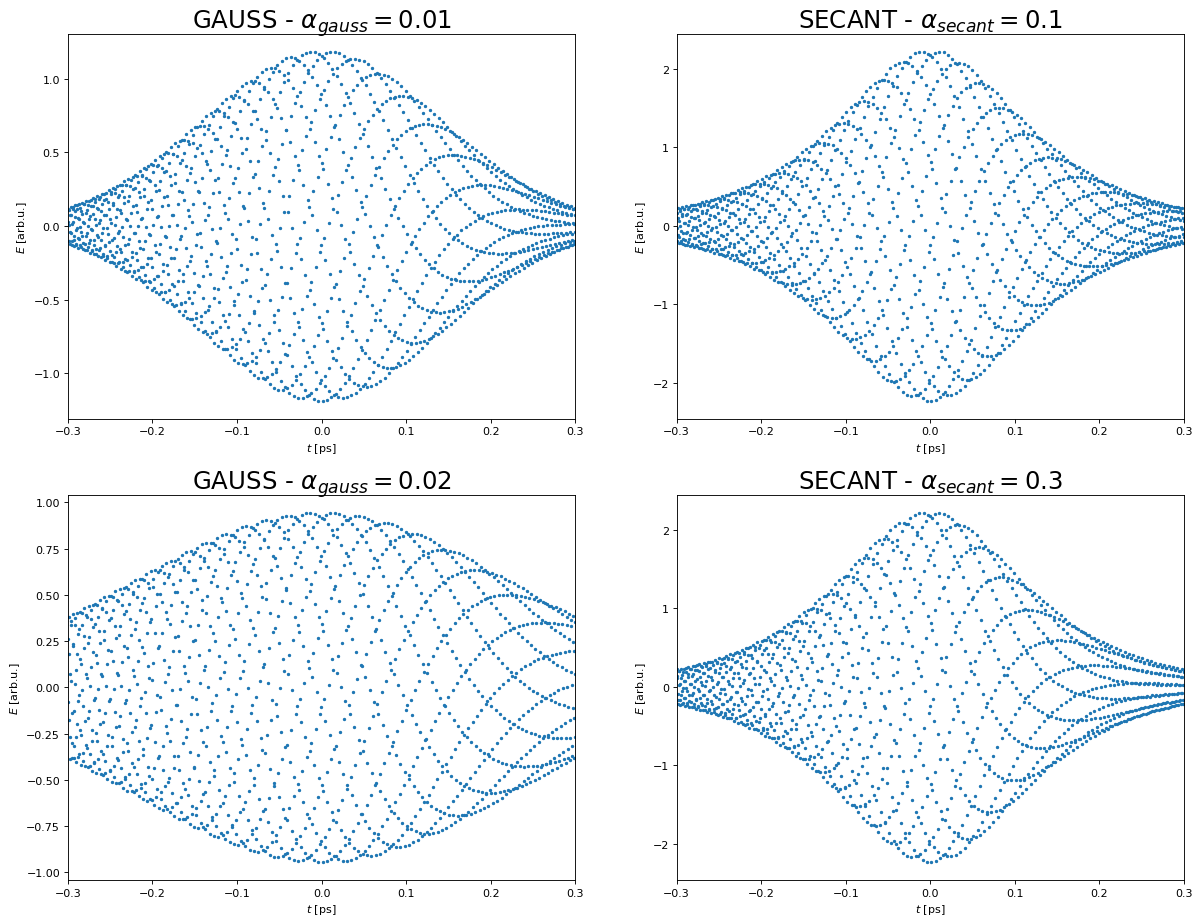

In [11]:
plt.figure(figsize=(18, max(alpha_gauss_values.size, alpha_secant_values.size) * 7), dpi=80)
for i in range(alpha_gauss_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 1)
    plt.title(r"GAUSS - $\alpha_{gauss}" + " = {}$".format(alpha_gauss_values[i]), fontsize=22)
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit, t_limit)
    plt.plot(t_values_1, np.real(E_gauss_values_1[:,i]), ".", markersize=4)

for i in range(alpha_secant_values.size):
    plt.subplot(max(alpha_gauss_values.size, alpha_secant_values.size), 2, 2 * i + 2)
    plt.title(r"SECANT - $\alpha_{secant}" + " = {}$".format(alpha_secant_values[i]), fontsize=22)
    plt.xlabel(r"$t$ [ps]")
    plt.ylabel(r"$E$ [arb.u.]")
    plt.xlim(-t_limit , t_limit)
    plt.plot(t_values_1, np.real(E_secant_values_1[:,i]), ".", markersize=4)

plt.show()

# Interferometric autocorrelation

![Setup for an interferometric autocorrelator](https://upload.wikimedia.org/wikipedia/en/d/dd/Optical-interferometric-autocorrelation-setup.png)

Setup for an interferometric autocorrelator, similar to the field autocorrelator above, with the following optics added:
- **L**: converging lens,
- **SHG**: second-harmonic generation crystal,
- **F**: spectral filter to block the fundamental wavelength.

(see https://en.wikipedia.org/wiki/Optical_autocorrelation)

The intensity recorded by the detecter is:

$$ I_M(\tau) = \int_{-\infty}^{+\infty}|(E(t)+E(t-\tau))^2|^2dt $$

later on we normalize the value so it will become 1 for very big or small $\tau$

In [12]:
def I_M_filtered(f, delta_phi, tau_values, A, tau_0, omega, alpha):
    I_M_values = np.array(())
    for tau in tau_values:
        func = lambda t: f(t, A, tau_0, omega, alpha) * f(t + tau, A, tau_0, omega, alpha) * (1 + np.cos(2 * omega * tau - 2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
        I_M_values = np.append(I_M_values,
                               2 * integrate.quad(func, - np.inf, np.inf)[0]) 
    return I_M_values

Number of $\tau$-values to calculate:

In [13]:
tau_limit = tau_0_laser * 4

Calculate the number of values so we can fft to at least $3 \cdot \omega$ 

$$3 \cdot \frac{\omega_{laser}}{2\pi} < f_{nyq} = \frac{f_{sampling}}{2} = \frac{\frac{\textit{number_tau_values}}{\textit{tau_limit} \cdot 2}}{2} $$

$$\Rightarrow \textit{number_tau_values} = \frac{6}{\pi} \cdot \textit{tau_limit} \cdot \omega_{laser} $$

"//100 * 100 + 100" so we don't get an integer multiple (which brings weird results)

In [14]:
number_tau_values = int((6 / np.pi * tau_limit * omega_laser)//100 * 100 + 100)

In [15]:
def gen_I_M_filtered_values(f, delta_phi, tau_limit, number_tau_values, alpha_values,  A, tau_0, omega):
    tau_values = np.linspace(-tau_limit, tau_limit, number_tau_values)
    I_M_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        I_M_values[:,i] = I_M_filtered(f, delta_phi, tau_values, A[i], tau_0, omega, alpha_values[i])
    return tau_values, I_M_values

In [16]:
while(True):
    answer_1 = input('Should data be loaded from file (l) or generated (g)?: ')
    if answer_1 == "l":
        path = r"../../Data/Autocorrelator/Simulation/" + \
        r"Autocorrelation_Simulation_Gauss_2018-10-01 15_52_55.595168.txt"        
        data = np.loadtxt(path)
        if data[0, 0] == 0:
            laser_type = "gauss"
        elif data[0, 0] == 1:
            laser_type = "secant"
        alpha_values = data[0, 1:]
        tau_values_1 = data[1:, 0]
        I_M_values_1 = data[1:, 1:]
        break
    if answer_1 == "g":
        while(True):
            answer_2 = input('Should we generate and save for gauss (g) or secant (s) pulse?: ')   
            if answer_2 == "g":
                alpha_values = alpha_gauss_values
                A = A_gauss
                laser_type = "gauss"
                tau_values_1, I_M_filtered_values_1 = gen_I_M_filtered_values(f_gauss, delta_phi_gauss, tau_limit, number_tau_values,
                                                                      alpha_values,  A,
                                                                      tau_0_laser, omega_laser)        
                path = r"../../Data/Autocorrelator/Simulation/"
                data = np.empty((tau_values_1.size + 1, alpha_values.size + 1))
                data[0] = np.append(0, alpha_values)
                data[1:] = np.append(tau_values_1[:, np.newaxis], I_M_filtered_values_1, axis=1)
                np.savetxt(path + "Autocorrelation_Simulation_Gauss_"
                           + str(datetime.now()).replace(":", "_") 
                           + ".txt", data,
                           header = "tau_values | I", comments=" first line corresponds to (0=Gauss or 1=Secant) and then alpha_values")
                break
            if answer_2 == "s":
                alpha_values = alpha_secant_values
                A = A_secant
                laser_type = "secant"
                tau_values_1, I_M_filtered_values_1 = gen_I_M_filtered_values(f_secant, delta_phi_secant, tau_limit, number_tau_values,
                                                                      alpha_values,  A,
                                                                      tau_0_laser, omega_laser)        
                path = r"../../Data/Autocorrelator/Simulation/"
                data = np.empty((tau_values_1.size + 1, alpha_values.size + 1))
                data[0] = np.append(1, alpha_values)
                data[1:] = np.append(tau_values_1[:, np.newaxis], I_M_filtered_values_1, axis=1)
                np.savetxt(path + "Autocorrelation_Simulation_Secant_"
                           + str(datetime.now()).replace(":", "_") 
                           + ".txt", data,
                           header = "tau_values | I", comments=" first line corresponds to (0=Gauss or 1=Secant) and then alpha_values")
                break
        break

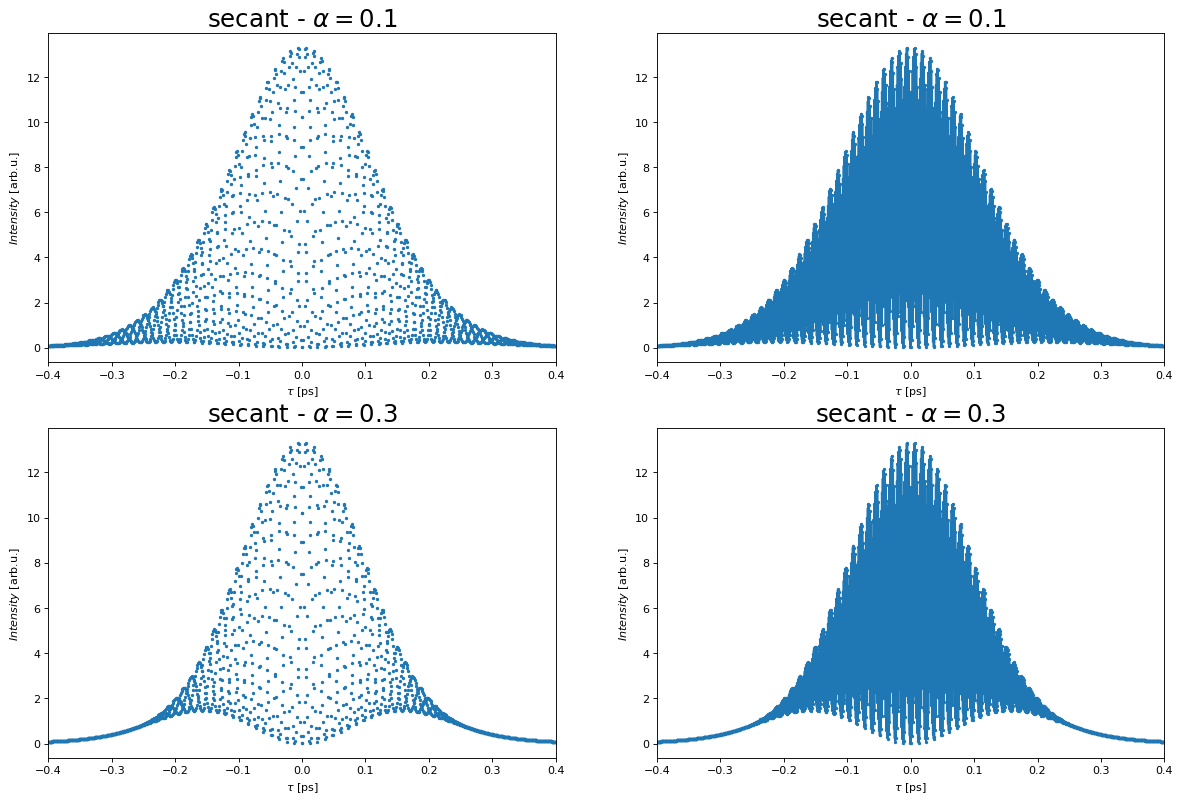

In [17]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", markersize=4)
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", ls="-", markersize=4)   

plt.show()

## Calculate envelope

In [18]:
minima_number_samples = 3

In [19]:
tau_envelope_values = []
I_M_envelope_values = []

for i in range(alpha_values.size):
    tau_envelope_values.append([])
    I_M_envelope_values.append([])
    # order=3 means that it checks the local minimum for three neighbors each side
    mask_local_min = signal.argrelmin(I_M_filtered_values_1[:,i], order=minima_number_samples)
    tau_envelope_values[:][i].append(tau_values_1[mask_local_min].tolist())
    I_M_envelope_values[:][i].append(I_M_filtered_values_1[:,i][mask_local_min].tolist())

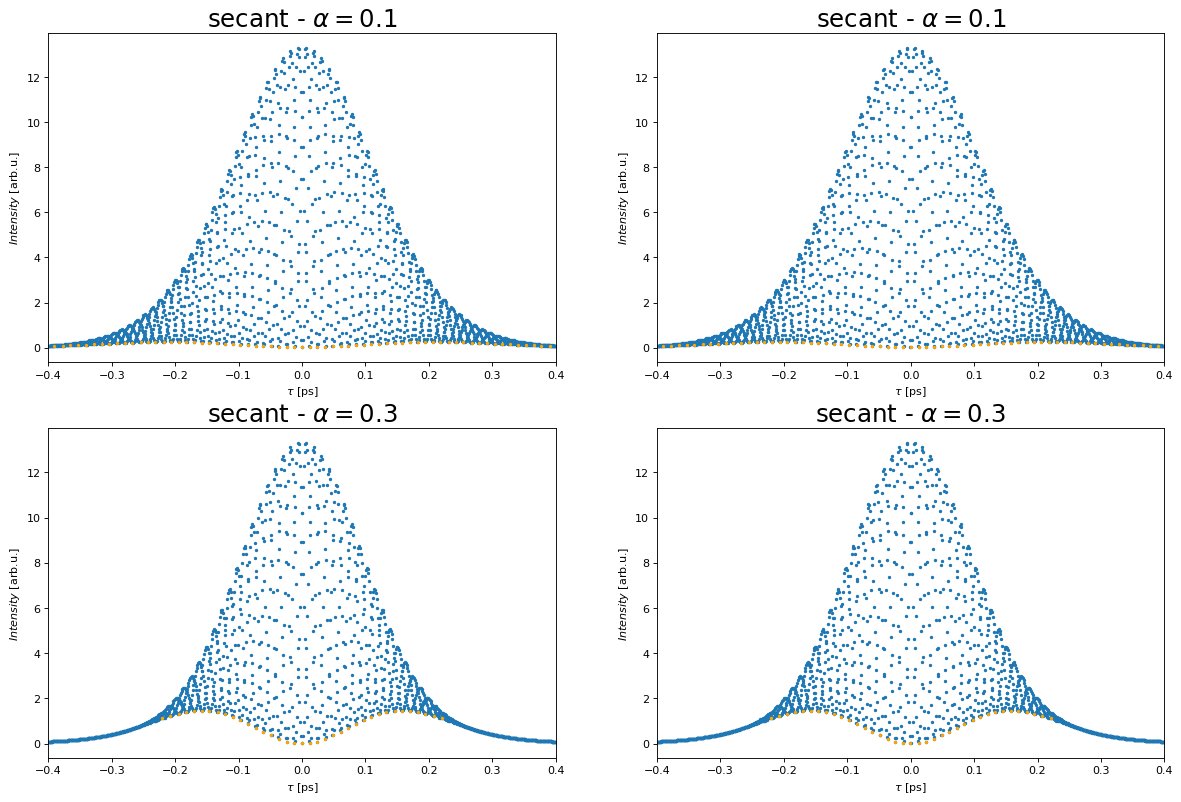

In [20]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", markersize=4)
    plt.plot(tau_envelope_values[:][i][0], I_M_envelope_values[:][i][0], ".", markersize=4, color="orange")
   
 
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", markersize=4)
    plt.plot(tau_envelope_values[:][i][0], I_M_envelope_values[:][i][0], ".", markersize=4, color="orange")

plt.show()

## Calculate envelope with known alpha_values
(see Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860)

The lower bound (minima envelope) of the MOSAIC trace is therefore given by

$$S^{min}_{MOSAIC}(\tau)= 1 + \frac{1}{2} \cdot g(\tau) - \frac{1}{2} \cdot [g_s^2(\tau)+g_c^2(\tau)]^{1/2}$$

with 

$$g(\tau)=\int f(t)f(t+\tau)dt$$
$$g_s(\tau)=\int f(t)f(t+\tau)sin(2\Delta\phi)dt$$
$$g_c(\tau)=\int f(t)f(t+\tau)cos(2\Delta\phi)dt$$

and

$$E(t) \sim f(t)$$
$$\Delta \phi(t, \tau) = \phi(t + \tau) - \phi(t)$$
$$\phi_{gauss}(t) = \frac{at^2}{2}$$
$$\int f(t) dt = 1$$

In [21]:
def g(tau, f, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]
    
def g_s(tau, f, delta_phi, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha) 
                                               * np.sin(2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]

def g_c(tau, f, delta_phi, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha) 
                                               * np.cos(2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]

In [22]:
def S_min(tau_values, f, delta_phi, A, tau_0, omega, alpha):
    S_min_values = np.array(())
    for tau in tau_values:
        S_min_values = np.append(S_min_values, 2 * g(tau, f, A, tau_0, omega, alpha) 
                                 - 2 *(g_s(tau, f, delta_phi, A, tau_0, omega, alpha)**2 
                                     + g_c(tau, f, delta_phi, A, tau_0, omega, alpha)**2)**(1/2))
    return S_min_values

In [23]:
def gen_S_min_values(tau_limit, number_tau_values, alpha_values,
                     f, delta_phi, A, tau_0, omega):
    tau_values = np.linspace(-tau_limit, tau_limit, number_tau_values)
    S_min_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        S_min_values[:,i] = S_min(tau_values, f, delta_phi, A[i],
                                  tau_0, omega, alpha_values[i])
    return tau_values, S_min_values

In [24]:
if laser_type == "gauss":
    tau_values_3, S_min_values_3 = gen_S_min_values(tau_limit, number_tau_values,
                                                    alpha_values, f_gauss,
                                                    delta_phi_gauss, A,
                                                    tau_0_laser, omega_laser)  
elif laser_type == "secant":
    tau_values_3, S_min_values_3 = gen_S_min_values(tau_limit, number_tau_values,
                                                    alpha_values, f_secant,
                                                    delta_phi_secant, A,
                                                    tau_0_laser, omega_laser)  


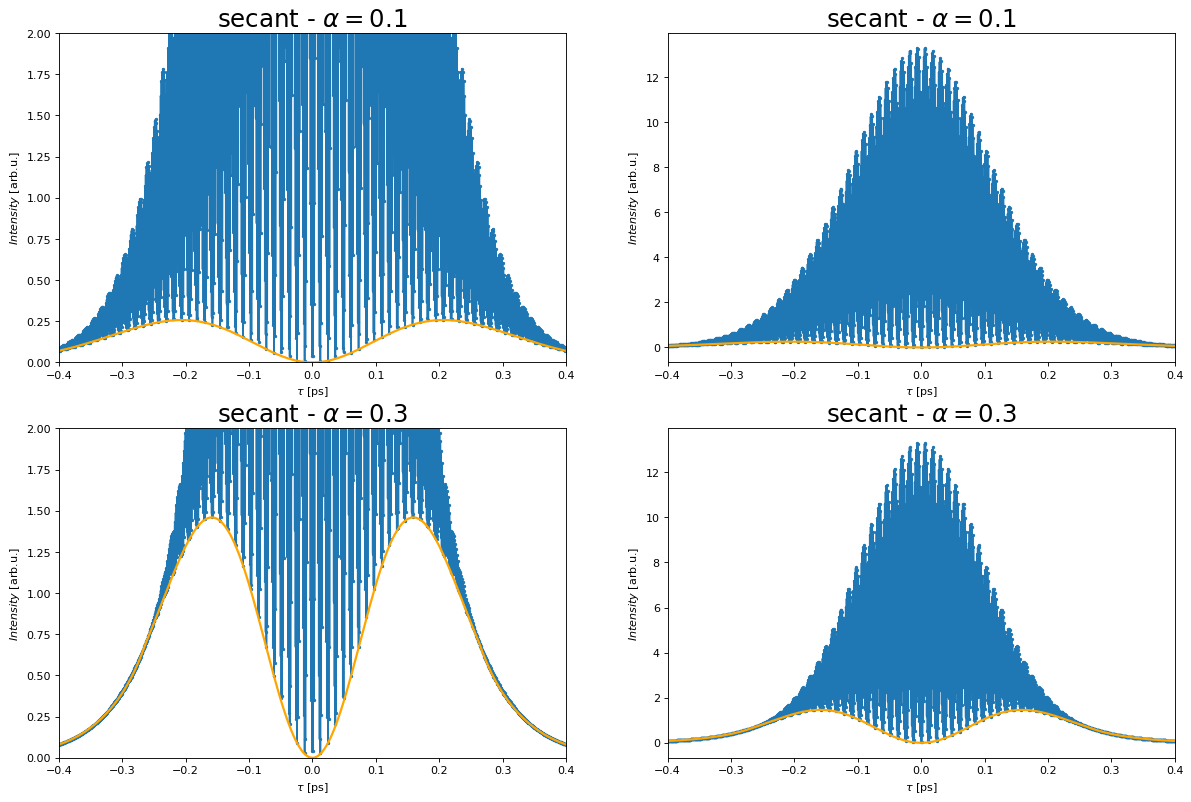

In [25]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.ylim(0, 2)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_3, S_min_values_3[:,i], linewidth=2, color="orange")
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_3, S_min_values_3[:,i], linewidth=2, color="orange")

plt.show()

## Fit envelope and find out if we get the correct alpha_value

In [26]:
def calc_S_min_alpha_fit_values(f, delta_phi, tau_envelope_values, I_M_envelope_values, tau_0, omega):
    # A[0] because A is (mostly) independent of alpha
    S_min_fit = lambda tau_values, alpha : S_min(tau_values, f, delta_phi, A[0], tau_0, omega, alpha)
    alpha_opt = np.empty(len(tau_envelope_values))
    alpha_cov = np.empty((len(tau_envelope_values), 1))
    for i in range(len(tau_envelope_values)):
        alpha_opt[i], alpha_cov[i]  = optimize.curve_fit(S_min_fit, tau_envelope_values[:][i][0], I_M_envelope_values[:][i][0], p0=0.2)        
        #set_trace()
    return alpha_opt, alpha_cov

In [27]:
if laser_type == "gauss":
    alpha_fit_opt, alpha_fit_cov  = calc_S_min_alpha_fit_values(f_gauss, delta_phi_gauss, tau_envelope_values, I_M_envelope_values, tau_0_laser, omega_laser)
    tau_values_4, S_min_fit_values_4 = gen_S_min_values(tau_limit, number_tau_values,
                                                    alpha_fit_opt, f_gauss,
                                                    delta_phi_gauss, A,
                                                    tau_0_laser, omega_laser)    
elif laser_type == "secant":
    alpha_fit_opt, alpha_fit_cov  = calc_S_min_alpha_fit_values(f_secant, delta_phi_secant, tau_envelope_values, I_M_envelope_values, tau_0_laser, omega_laser)
    tau_values_4, S_min_fit_values_4 = gen_S_min_values(tau_limit, number_tau_values,
                                                    alpha_fit_opt, f_secant,
                                                    delta_phi_secant, A,
                                                    tau_0_laser, omega_laser)   


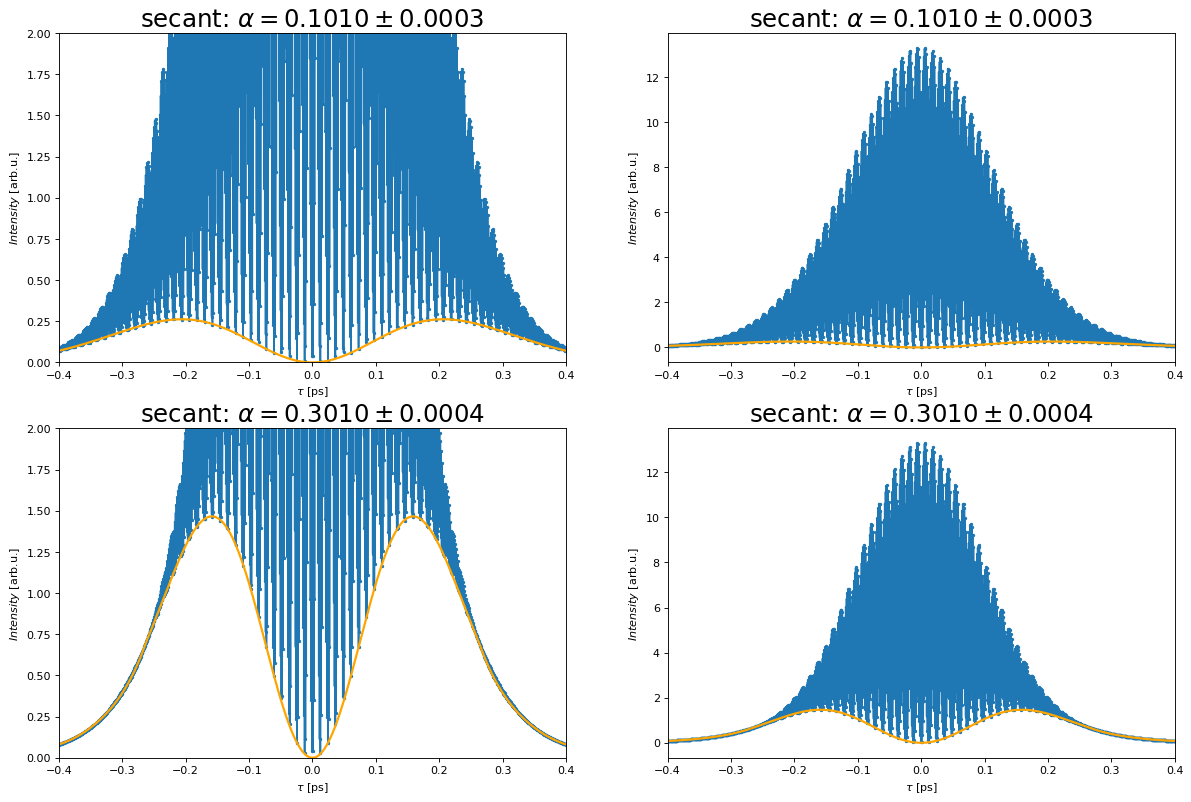

In [28]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)

for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_type + r": $\alpha = %.04f \pm %.04f$" % (alpha_fit_opt[i], np.sqrt(np.diag(alpha_fit_cov[i]))), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.ylim(0, 2)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_4, S_min_fit_values_4[:,i], linewidth=2, color="orange")
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_type + r": $\alpha = %.04f \pm %.04f$" % (alpha_fit_opt[i], np.sqrt(np.diag(alpha_fit_cov[i]))), fontsize=22)
    plt.xlabel(r"$\tau$ [ps]")
    plt.ylabel(r"$Intensity$ [arb.u.]")
    plt.xlim(-tau_limit, tau_limit)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_4, S_min_fit_values_4[:,i], linewidth=2, color="orange")

plt.show()